# 1: LightGBM SHAP for predicting use of thrombolysis

This model use 10 features:

* stroke_team_id
* stroke_severity
* prior_disability
* age
* infarction
* onset_to_arrival_time
* precise_onset_known
* onset_during_sleep
* arrival_to_scan_time
* afib_anticoagulant

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import pickle

from dataclasses import dataclass
from xgboost import XGBClassifier

/home/anna/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/anna/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizat

In [2]:
import stroke_utilities.process_data as process_data
import stroke_utilities.models as models
import stroke_utilities.scenario as scenario

## Set up paths and filenames

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './stroke_utilities/data/'
    data_save_path: str = './stroke_utilities/data/'
    output_folder = './stroke_utilities/output/'
    model_folder = './stroke_utilities/models'
    model_text = 'lgbm_decision_'
    notebook: str = '01_'

paths = Paths()

## Load data

In [4]:
# Load data
train = pd.read_csv(paths.data_read_path + 'cohort_10000_train.csv')
train['stroke_team_id'] = train['stroke_team_id'].astype('category')
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

In [5]:
# Put data into the format for model
features_to_model = [
    'stroke_team_id',
    'stroke_severity',
    'prior_disability',
    'age',
    'infarction',
    'onset_to_arrival_time',
    'precise_onset_known',
    'onset_during_sleep',
    'arrival_to_scan_time',
    'afib_anticoagulant',
    # 'year',    
    'thrombolysis'
]

In [6]:
train = train[features_to_model]
test = test[features_to_model]

In [7]:
train = process_data.restrict_data_to_range(train, 2016, 2018, 'year')
test = process_data.restrict_data_to_range(test, 2016, 2018, 'year')

In [8]:
X_train, y_train = process_data.split_X_and_y(train, 'thrombolysis')
X_test, y_test = process_data.split_X_and_y(test, 'thrombolysis')

In [9]:
features = list(X_train)

features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

In [10]:
X_train = process_data.one_hot_encode_column(X_train, 'stroke_team_id', prefix='team')

X_test = process_data.one_hot_encode_column(X_test, 'stroke_team_id', prefix='team')

In [11]:
# Get features
features_ohe = list(X_train)

features_ohe[:15]
# the remaining features are all "team_X" for increasing X

['stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant',
 'team_1',
 'team_2',
 'team_3',
 'team_4',
 'team_5',
 'team_6',
 'team_7',
 'team_8',
 'team_9',
 'team_10',
 'team_11',
 'team_12',
 'team_13',
 'team_14',
 'team_15',
 'team_16',
 'team_17',
 'team_18',
 'team_19',
 'team_20',
 'team_21',
 'team_22',
 'team_23',
 'team_24',
 'team_25',
 'team_26',
 'team_27',
 'team_28',
 'team_29',
 'team_30',
 'team_31',
 'team_32',
 'team_33',
 'team_34',
 'team_35',
 'team_36',
 'team_37',
 'team_38',
 'team_39',
 'team_40',
 'team_41',
 'team_42',
 'team_43',
 'team_44',
 'team_45',
 'team_46',
 'team_47',
 'team_48',
 'team_49',
 'team_50',
 'team_51',
 'team_52',
 'team_53',
 'team_54',
 'team_55',
 'team_56',
 'team_57',
 'team_58',
 'team_59',
 'team_60',
 'team_61',
 'team_62',
 'team_63',
 'team_64',
 'team_65',
 'team_66',
 'team_67',
 'team_68',
 'team_6

## Fit model

In [12]:
# Define and Fit model
model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Save model to file:

In [13]:
with open(f'{paths.model_folder}/model.p', 'wb') as fp:
    pickle.dump(model, fp)

In [14]:
# Get predictions
predicted = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)[:,1]

# Show overall accuracy
accuracy = np.mean(predicted == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.827


In [15]:
with open(f'{paths.model_folder}/model.p', 'rb') as fp:
    model = pickle.load(fp)

## Create SHAP explainer

In [16]:
explainer = models.create_shap_TreeExplainer(model)

Save SHAP model to file:

In [17]:
with open(f'{paths.model_folder}/shap_explainer.p', 'wb') as fp:
    pickle.dump(explainer, fp)

## Create SHAP explainer in probability units

In [18]:
explainer_prob = shap.TreeExplainer(
    model, 
    data=X_train, 
    model_output="probability", 
    # feature_perturbation="interventional"
    )

Save SHAP model to file:

In [19]:
with open(f'{paths.model_folder}/shap_explainer_probability.p', 'wb') as fp:
    pickle.dump(explainer_prob, fp)

In [20]:
# shap_values_prob, shap_values_extended_prob = models.calculate_shap_values(explainer_prob, X_test)

shap_values_extended_prob = explainer_prob(X_test)
shap_values_prob = explainer_prob.shap_values(X_test)

 98%|===================| 9757/10000 [00:11<00:00]        

In [21]:
shap_values_extended_prob[0]

.values =
array([ 1.20774461e-01, -5.86449688e-02, -3.91940224e-02,  7.80457592e-02,
        5.45152410e-02,  6.88821926e-02,  1.00034121e-02,  1.17080245e-02,
        2.84794241e-02, -5.22213617e-05,  1.28106690e-03,  3.54639117e-04,
       -2.91606834e-03,  0.00000000e+00,  1.24174116e-03,  0.00000000e+00,
       -1.50923613e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.30483059e-04,  1.46215676e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.46544755e-01,  0.00000000e+00, -1.53911067e-04,
       -1.41407821e-03, -6.35288421e-04,  0.00000000e+00, -7.74445196e-04,
        1.68866508e-04, -1.00748114e-04,  0.00000000e+00,  0.00000000e+00,
       -1.35767042e-03,  0.00000000e+00,  3.50416916e-04,  0.00000000e+00,
        2.11601262e-03,  0.00000000e+00,  0.00000000e+00,  5.96672482e-05,
       -1.43021267e-04,  0.00000000e+00,  9.33155771e-04,  0.00000000e+00,
        1.20041698e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.73144

## Create SHAP values for the test data

In [22]:
# shap_values, shap_values_extended = models.calculate_shap_values(explainer, X_test)
shap_values_extended = explainer(X_test)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [23]:
type(shap_values[1][0])

numpy.float32

In [24]:
shap_values_extended[0]

.values =
array([ 8.05260241e-01, -3.69554341e-01, -2.76785493e-01,  4.47453558e-01,
        2.50044733e-01,  4.39587533e-01,  3.94758806e-02,  1.75443679e-01,
        2.40202188e-01,  2.61562131e-03,  4.51945979e-03,  1.21334649e-03,
       -1.28792524e-02,  2.47736089e-03,  6.43194746e-03,  1.41001935e-03,
        1.21900826e-04, -2.12001754e-03,  1.14044861e-03, -6.39905594e-03,
        2.20003631e-03,  6.66771666e-04, -1.54301785e-02,  3.66613828e-03,
        3.45913600e-03, -9.14633512e-01,  4.53487877e-03, -3.14923120e-03,
       -5.09779667e-03, -1.98410382e-03,  6.03572838e-03, -1.64598692e-03,
       -6.09510986e-04, -9.49344481e-04, -1.99882255e-04,  2.41859583e-03,
       -4.11782833e-03,  2.81409826e-03,  4.00006352e-03, -1.31056993e-03,
        6.67830510e-03,  2.32495095e-05, -4.95526008e-03,  3.02924472e-03,
       -1.16550887e-03,  1.96690159e-03,  5.06631751e-03,  4.34360874e-04,
        9.11967363e-04, -1.35510566e-03,  2.13733176e-04, -3.55469878e-04,
       -1.08515

In [25]:
# shap_values_extended.feature_names

## Get mean absolute SHAP values

In [26]:
# Calculate mean SHAP value for each feature (across all instances)
df_shap_values_mean = pd.DataFrame(index=shap_values_extended.feature_names)
df_shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
df_shap_values_mean['abs_mean_shap'] = np.abs(df_shap_values_mean['mean_shap'])
df_shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df_shap_values_mean['rank'] = df_shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values

## Get stroke team SHAP

In [27]:
team_features = sorted(list(set(features_ohe) - set(features)))

In [28]:
team_shap = df_shap_values_mean.loc[team_features].sort_values('mean_shap', ascending=False)
team_shap['rank'] = team_shap['mean_shap'].rank(
    ascending=False).values
team_shap['stroke_team_id'] = [t.split('team_')[-1] for t in team_shap.index]
team_shap = team_shap.astype(dtype={'rank': int, 'stroke_team_id': int})

team_shap

,mean_shap,abs_mean_shap,mean_abs_shap,rank,stroke_team_id
team_22,0.001435,0.001435,0.013574,1,22
team_32,0.001024,0.001024,0.007500,2,32
team_62,0.001006,0.001006,0.005481,3,62
team_113,0.000891,0.000891,0.014367,4,113
team_97,0.000834,0.000834,0.012402,5,97
...,...,...,...,...,...
team_17,-0.001384,0.001384,0.008049,115,17
team_34,-0.001667,0.001667,0.010646,116,34
team_75,-0.001916,0.001916,0.010728,117,75
team_50,-0.002627,0.002627,0.014257,118,50


In [29]:
feature_names_ohe = list(X_train)

In [30]:
X_test

,stroke_severity,prior_disability,age,infarction,onset_to_arrival_time,precise_onset_known,onset_during_sleep,arrival_to_scan_time,afib_anticoagulant,team_1,...,team_110,team_111,team_112,team_113,team_114,team_115,team_116,team_117,team_118,team_119
0,10,2,52.5,1.0,70,1,0,24.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15,1,77.5,1.0,55,1,0,24.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,4,82.5,1.0,93,1,0,27.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,72.5,1.0,69,0,1,62.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,87.5,0.0,98,1,0,7.0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11,3,62.5,1.0,60,1,0,14.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,28,2,92.5,1.0,5,1,0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,11,3,87.5,1.0,63,1,0,34.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,28,3,87.5,1.0,60,1,0,2.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
test.columns

Index(['stroke_team_id', 'stroke_severity', 'prior_disability', 'age',
       'infarction', 'onset_to_arrival_time', 'precise_onset_known',
       'onset_during_sleep', 'arrival_to_scan_time', 'afib_anticoagulant',
       'thrombolysis'],
      dtype='object')

In [32]:
# Set up list for storing patient data and hospital SHAP
feature_data_with_shap = []

# Get mean SHAP for stroke team when patient attending that stroke team
unique_stroketeams_list = list(np.unique(test['stroke_team_id']))
stroke_team_mean_shap = []
# Loop through stroke teams
for stroke_team in unique_stroketeams_list:
    # Identify rows in test data that match each stroke team
    mask = test['stroke_team_id'] == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = f'team_{stroke_team}'
    index = feature_names_ohe.index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Get mean
    mean_shap = np.mean(stroke_team_shap)
    # Store mean
    stroke_team_mean_shap.append(mean_shap)
    # Get and store feature data and add SHAP
    feature_data = X_test[mask]
    feature_data['Hospital_SHAP'] = stroke_team_shap
    feature_data_with_shap.append(feature_data)

# Concatenate and save feature_data_with_shap
feature_data_with_shap = pd.concat(feature_data_with_shap, axis=0)
# feature_data_with_shap.to_csv(
#    f'./predictions/{notebook}_{model_text}_feature_data_with_hospital_shap.csv', 
#     index=False)

# Create and save shap mean value per hospital
hospital_data = pd.DataFrame()
hospital_data["stroke_team_id"] = unique_stroketeams_list
hospital_data["shap_mean"] = stroke_team_mean_shap
# hospital_data.to_csv(
#     f'./predictions/{notebook}_{model_text}_mean_shap_per_hospital.csv', 
#     index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [33]:
hospital_data

,stroke_team_id,shap_mean
0,1,-0.306902
1,2,-0.208262
2,3,-0.722472
3,4,0.749764
4,5,-0.585027
...,...,...
114,115,-0.659037
115,116,-0.050079
116,117,0.097771
117,118,-0.074880


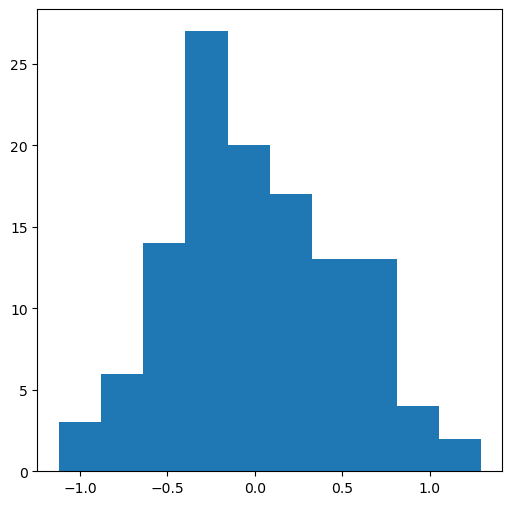

In [34]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(hospital_data['shap_mean'])

plt.show()

In [35]:
mean_shap = np.mean(hospital_data['shap_mean'])
std_shap = np.std(hospital_data['shap_mean'])
print(f'Mean hospital SHAP: {mean_shap:0.3f}')
print(f'Mean hospital SHAP STDdev: {std_shap:0.3f}')

Mean hospital SHAP: 0.001
Mean hospital SHAP STDdev: 0.480


## Extract benchmark ranking

In [36]:
hospital_data = hospital_data.sort_values('shap_mean', ascending=False)
hospital_data['Rank'] = np.arange(len(hospital_data))

hospital_data

,stroke_team_id,shap_mean,Rank
52,53,1.295192,0
105,106,1.097801,1
13,14,0.956832,2
83,84,0.938966,3
56,57,0.895700,4
...,...,...,...
82,83,-0.774275,114
15,16,-0.782008,115
101,102,-0.958527,116
102,103,-1.121825,117


In [37]:
hospital_data.to_csv(f'{paths.output_folder}/benchmark_codes.csv', index=False)

In [38]:
benchmark_team_id_list = hospital_data['stroke_team_id'].values[:25]

benchmark_team_id_list

array([ 53, 106,  14,  84,  57,  66,   4, 108,  45,  11,  94,  82,  63,
        74,  58,  20, 113,  89,  48,  41, 107,  93,  34,  92,  19])